# Predict ligand profiling using `kissim`

## Aim of this notebook

In order to assess the predictive power of `kissim`, we here choose a ligand-centric evaluation. 
We will compare if `kissim` can predict on- and off-targets determined in ligand profiling studies.

- Kinase-kinase distance dataset (use KinMap kinase names): Select kinases from profiling dataset by query ligand
- Kinase-ligand profiling dataset (use KinMap kinase names and PKIDB ligand names): Select kinases from distances dataset by the ligand's on-target
- Merge both datasets and keep only kinases that have measurements in both datasets
- Rank kinases by distances
- Calculuate enrichment factors and enrichment plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import data, evaluation, visualization

In [3]:
plt.style.use("seaborn")

## Define parameters

In [4]:
# The only global that can be changed in this notebook
LIGAND_PROFILING_METHOD = "karaman"

KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

## Kinase-kinase distances dataset

__Criteria__: 

- Filters out kinases whose names cannot be mapped to KinMap kinase names.

In [5]:
# Full dataset (reported only, not further used)
kissim_df = data.distances.kissim(structure_kinase_mapping_by="minimum", kinmap_kinases=False)
print(f"Kinase distance matrix shape: {kissim_df.shape}")

Kinase distance matrix shape: (292, 292)


In [6]:
# Reduced dataset
kissim_df = data.distances.kissim(structure_kinase_mapping_by="minimum", kinmap_kinases=True)
print(f"Kinase distance matrix shape: {kissim_df.shape}")
kissim_df.iloc[:5, :5]

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
73         DCLK1                  DCAMKL1
133       JAK1-b                   JAK1_b
135       JAK2-b                   JAK2_b
176       MSK1-b                   MSK1_b
200       PI4K2A  unknown (not in KinMap)
201       PI4K2B  unknown (not in KinMap)
202        PI4KB  unknown (not in KinMap)
203       PIK3C3  unknown (not in KinMap)
236       RSK1-b                   RSK1_b
238       RSK2-b                   RSK2_b
267       TYK2-b                   TYK2_b
284        p110a  unknown (not in KinMap)
285        p110d  unknown (not in KinMap)
286        p110g  unknown (not in KinMap)


Kinase distance matrix shape: (285, 285)


,AAK1,ABL1,ABL2,ACK,ACTR2
AAK1,0.000000,0.239739,0.246362,0.246718,0.261379
ABL1,0.239739,0.000000,0.032393,0.137668,0.280255
ABL2,0.246362,0.032393,0.000000,0.148981,0.294966
ACK,0.246718,0.137668,0.148981,0.000000,0.293667
ACTR2,0.261379,0.280255,0.294966,0.293667,0.000000


## Kinase-ligand profiling dataset

__Criteria__:

- Load dataset with FDA-approved PKIDB ligands only.
- Filters out ligands whose names cannot be mapped onto PKIDB ligand names.

In [7]:
# Full dataset (reported only, not further used)
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD)
print(f"Number of kinases (full dataset): {profiling_df.shape[0]}")
print(f"Number of ligands (full dataset): {profiling_df.shape[1]}")

Number of kinases (full dataset): 268
Number of ligands (full dataset): 30


In [8]:
# Reduced dataset
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD, pkidb_ligands=True, fda_approved=True)
print(f"Number of kinases (FDA-approved PKIDB ligands only): {profiling_df.shape[0]}")
print(f"Number of ligands (FDA-approved PKIDB ligands only): {profiling_df.shape[1]}")
profiling_df.head()

Changed ligand names (unknown names may be discarded - see function docstring):
           ligand.input            ligand.pkidb
0         Staurosporine  unknown (not in PKIDB)
1           JNJ-7706621  unknown (not in PKIDB)
2              MLN-8054  unknown (not in PKIDB)
3               PKC-412             Midostaurin
4              SU-14813  unknown (not in PKIDB)
5             SB-202190  unknown (not in PKIDB)
6             CP-724714  unknown (not in PKIDB)
7        VX-680/MK-0457  unknown (not in PKIDB)
9   Roscovitine/CYC-202  unknown (not in PKIDB)
10            SB-203580  unknown (not in PKIDB)
12            CP-690550             Tofacitinib
14              GW-2580  unknown (not in PKIDB)
16            GW-786034  unknown (not in PKIDB)
18               VX-745            Neflamapimod
19            SB-431542  unknown (not in PKIDB)
20              ZD-6474              Vandetanib
22         Flavopiridol  unknown (not in PKIDB)
24              MLN-518              Tandutinib
25      

Number of kinases (FDA-approved PKIDB ligands only): 268
Number of ligands (FDA-approved PKIDB ligands only): 16


,Midostaurin,Dasatinib,Gefitinib,Tofacitinib,Imatinib,Lapatinib,Sorafenib,Neflamapimod,Vandetanib,Sunitinib,Erlotinib,Tandutinib,Ruboxistaurin,Canertinib,Pelitinib,Vatalanib
AAK1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1200.0,NaN,900.0,NaN,3500.0,NaN
ABL1,NaN,0.53,NaN,NaN,12.0,NaN,680.0,730.0,270.0,830.0,310.0,NaN,NaN,1400.0,560.0,NaN
ABL2,NaN,0.17,NaN,NaN,10.0,NaN,2900.0,1900.0,69.0,1000.0,200.0,NaN,NaN,870.0,370.0,NaN
ALK2,NaN,620.00,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN,2500.0,NaN,1700.0,NaN,NaN
ALK4,NaN,330.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


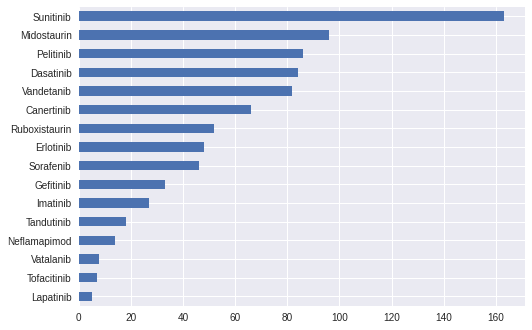

In [9]:
profiling_df.count().sort_values().plot(kind="barh");

### Ligands' on-targets dataset

__Criteria__: 

- Filters out ligands that are not available in the PKIDB or have no targets in the PKIDB.
- Filters out targets whose names cannot be mapped onto KinMap names

In [10]:
pd.set_option("max_colwidth", 100)
ligand_targets = data.targets.pkidb(profiling_df.columns, fda_approved=False)
ligand_targets

Changed kinase names (unknown names may be discarded - see function docstring):
   kinase.input            kinase.kinmap
0           nan  unknown (not in KinMap)
3         EPHA2                    EphA2
5          YES1                      YES
7        PDGFRB                   PDGFRb
17        NTRK1                     TRKA
18        CSF1R                      FMS
19       PDGFRA                   PDGFRa
22       PDGFRB                   PDGFRb
24        ERBB2                    ErbB2
30       PDGFRB                   PDGFRb
35       MAPK14                     p38a
36        VEGFA  unknown (not in KinMap)
38         PTK6                      BRK
39          TEK                     TIE2
41       PDGFRB                   PDGFRb
47        CSF1R                      FMS
48       PDGFRA                   PDGFRa
50        NR1I2  unknown (not in KinMap)
52        PDGFD  unknown (not in KinMap)
53          nan  unknown (not in KinMap)
56        ERBB2                    ErbB2


,ligand.input,targets.pkidb,targets.kinmap
0,Canertinib,[EGFR],[EGFR]
1,Erlotinib,[EGFR],[EGFR]
2,Gefitinib,[EGFR],[EGFR]
3,Neflamapimod,[MAPK14],[p38a]
4,Tandutinib,[FLT3],[FLT3]
5,Lapatinib,"[EGFR, ERBB2]","[EGFR, ErbB2]"
6,Pelitinib,"[EGFR, ERBB2]","[EGFR, ErbB2]"
7,Vatalanib,"[FLT1, KDR, FLT4]","[FLT1, KDR, FLT4]"
8,Tofacitinib,"[JAK1, JAK2, JAK3, TYK2]","[JAK1, JAK2, JAK3, TYK2]"
9,Vandetanib,"[EGFR, PTK6, TEK, RET]","[EGFR, BRK, TIE2, RET]"


### Ligand-kinase datasets

We merge now profiling and kinase similarity information into one dataset per ligand-kinase pair (_ligand-kinase dataset_). 

We only keep ligand-kinase pairs that
- have a minimum of `MIN_N_SHARED_KINASES` shared kinases
- have a minimum of `MIN_N_SHARED_ACTIVE_KINASES` shared active kinases, while activity is defined <= `KINASE_ACTIVITY_CUTOFF`

Select ligand-kinase pairs with enough coverage.

In [11]:
ligand_kinase_pairs = (
    ligand_targets[["ligand.input", "targets.kinmap"]]
    .explode("targets.kinmap")
    .to_numpy()
    .tolist()
)
print(f"Number of pairs (full dataset): {len(ligand_kinase_pairs)}")

ligand_kinase_pairs_selected = evaluation.kinase_ranks.curate_ligand_kinase_pairs(
    ligand_kinase_pairs,
    profiling_df,
    kissim_df,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    min_n_shared_kinases=MIN_N_SHARED_KINASES,
    min_n_shared_active_kinases=MIN_N_SHARED_ACTIVE_KINASES,
)
print(f"Number of pairs (filtered dataset): {len(ligand_kinase_pairs_selected)}")

Number of pairs (full dataset): 55
Number of pairs (filtered dataset): 41


## Enrichment

### Enrichment factor 

An enrichment factor is calculated as follows:

$EF_{x\%} = \frac{\frac{n_s}{n}}{\frac{N_s}{N}}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

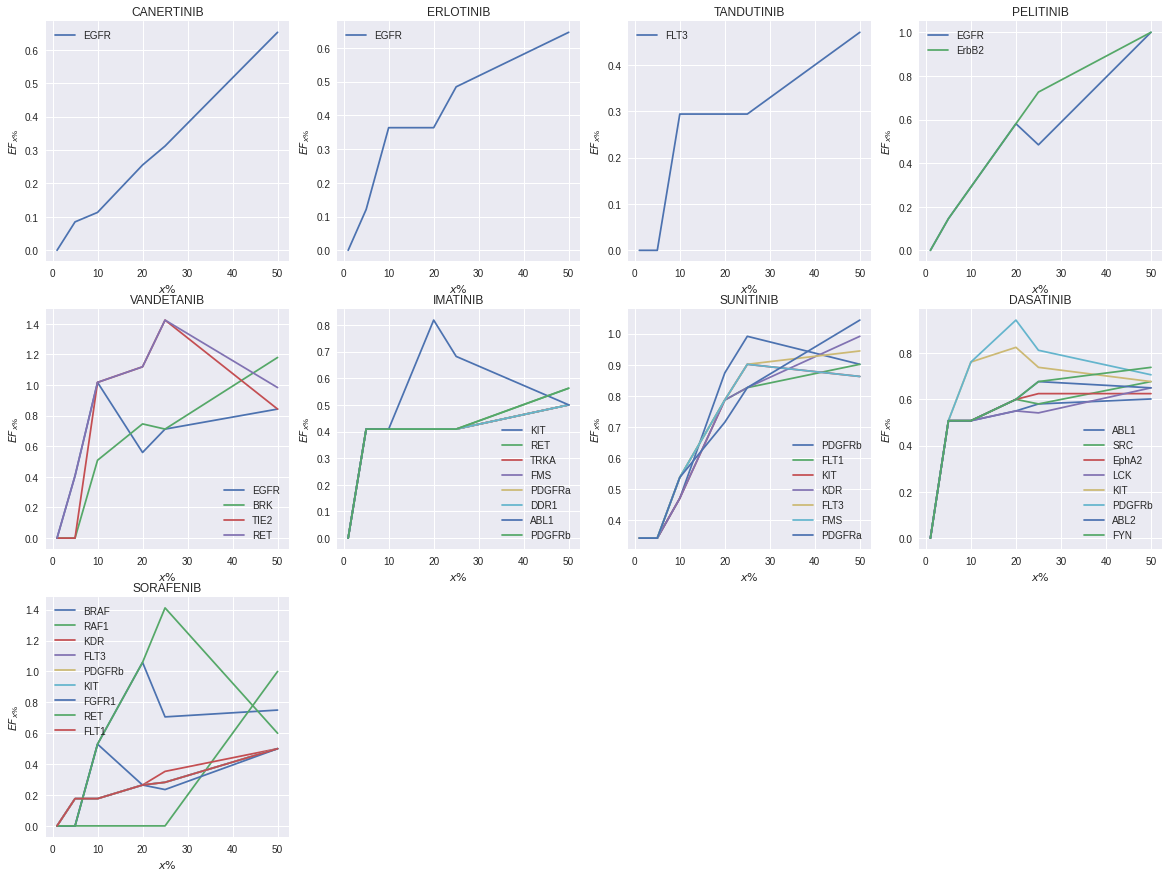

In [12]:
visualization.enrichment.enrichment_factor_plots(
    ligand_kinase_pairs_selected, profiling_df, kissim_df, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, KINASE_ACTIVITY_CUTOFF, KINASE_ACTIVITY_MAX
)

### Enrichment plots

For an enrichment plot, the x and y values are calculated as follows:

$x = \frac{N_s}{N}$, $y = \frac{n_s}{n}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

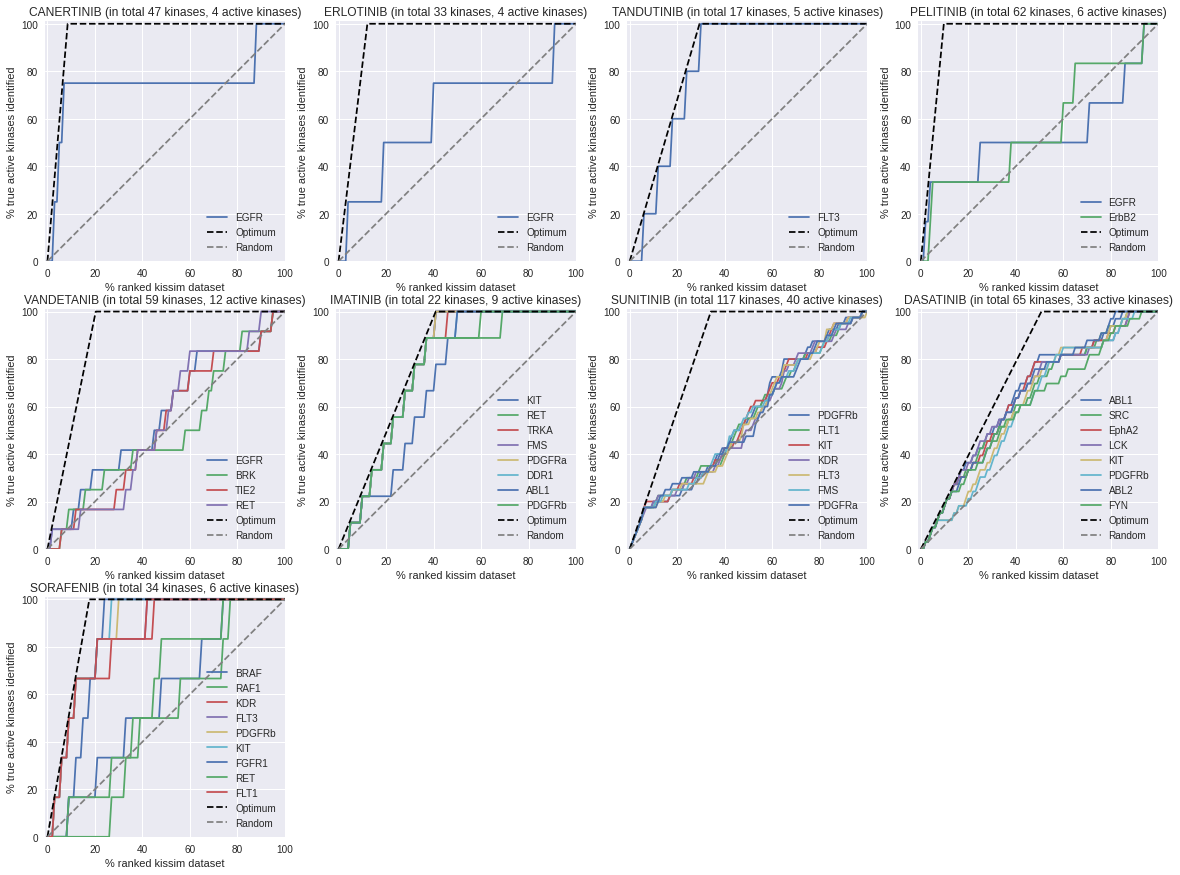

In [13]:
visualization.enrichment.enrichment_plots(
    ligand_kinase_pairs_selected, profiling_df, kissim_df, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, KINASE_ACTIVITY_CUTOFF, KINASE_ACTIVITY_MAX
)